In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import astropy.units as u
from astropy.cosmology import z_at_value

In [3]:
from lenstools.simulations.fastpm import FastPMSnapshot 
from lenstools.simulations.raytracing import DensityPlane, PotentialPlane, RayTracer
from lenstools.image.convergence import ConvergenceMap

In [4]:
%%bash
ls /home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/*

/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/000000
/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/attr-v2
/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/header

/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/Aemit:
000000
000001
attr-v2
header

/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/ID:
000000
000001
attr-v2
header

/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/Position:
000000
000001
attr-v2
header

/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/Velocity:
000000
000001
attr-v2
header


In [5]:
class MyFastPMSnapshot(FastPMSnapshot):
    
    def getHeader(self):

        #Initialize header
        header = dict()
        bf_header = self.fp["."].attrs

        ###############################################
        #Translate fastPM header into lenstools header#
        ###############################################

        #Number of particles/files
        header["num_particles_file"] = bf_header["NC"][0]**3
        header["num_particles_total"] = header["num_particles_file"]
        header["num_files"] = 1

        #Cosmology
        header["Om0"] = bf_header["OmegaM"][0]
        header["Ode0"] = 1. - header["Om0"]
        header["w0"] = -1.
        header["wa"] = 0.
        header["h"] = bf_header['HubbleParam'][0]

        #Box size in kpc/h
        header["box_size"] = bf_header["BoxSize"][0]*1.0e3

        #Masses
        header["masses"] = bf_header['MassTable']*header["h"]

        #################

        return header


In [6]:
snap_path = "/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/"
snap = MyFastPMSnapshot.open(snap_path)
snap.getPositions()

<Quantity [[2.7401862e+02,5.0935712e+02,3.2069873e+02],
           [2.1915390e+02,3.4077614e+01,3.2069864e+02],
           [2.4580267e+02,4.9541205e+02,3.2069861e+02],
           ...,
           [1.1087265e+02,3.3926782e+02,2.3716013e-05],
           [3.7900409e+02,4.0602298e+02,7.9517158e-05],
           [5.1093198e+02,6.1579662e+01,8.6754326e-06]] Mpc/h>

In [7]:
np.cbrt(16777241)

256.0001271565123

In [8]:
snap.positions.value.shape

(10501095, 3)

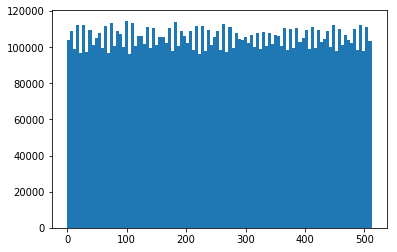

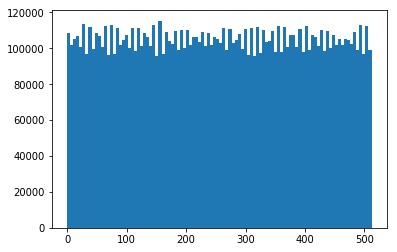

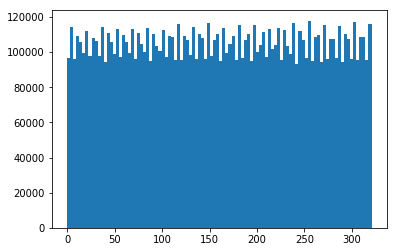

In [9]:
for i in xrange(3):
    plt.hist(snap.positions[:,i].value, bins = 100);
    plt.show()

---

0


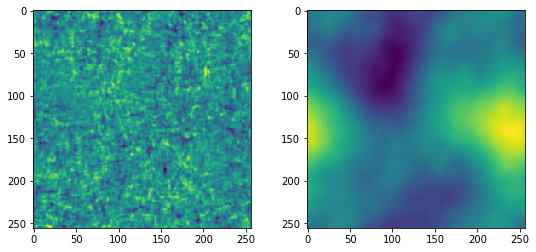

1


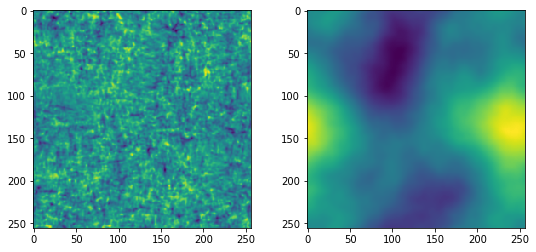

2


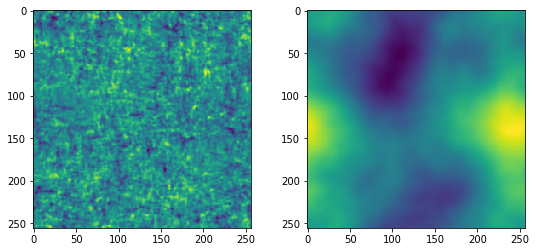

3


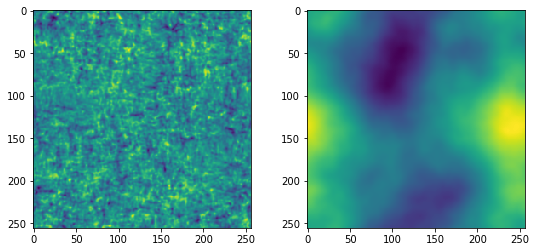

4


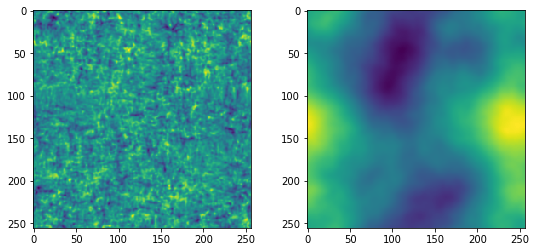

5


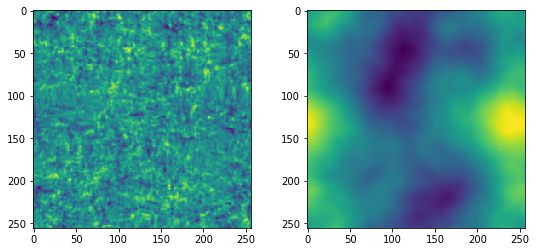

6


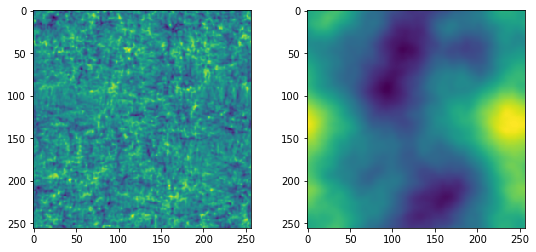

7


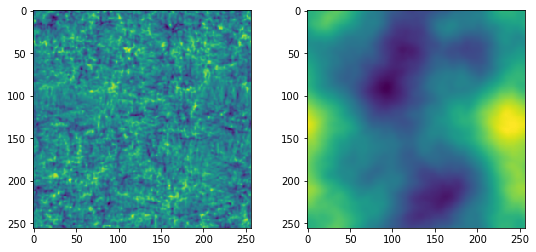

8


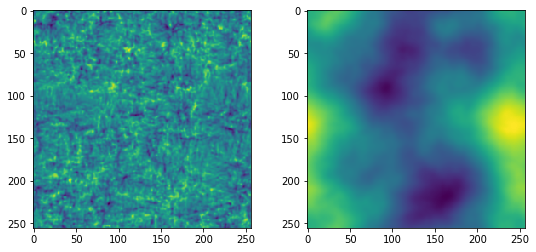

9


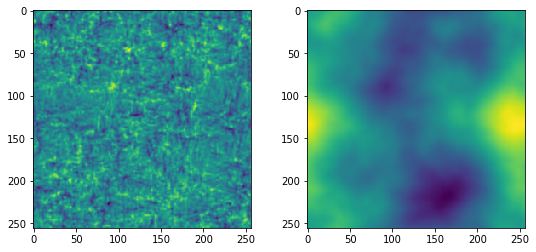

10


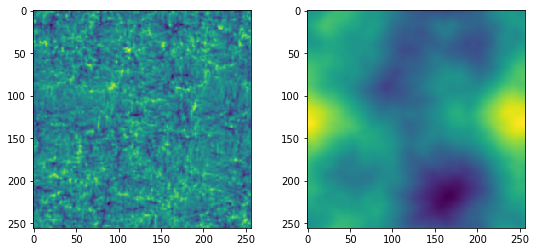

11


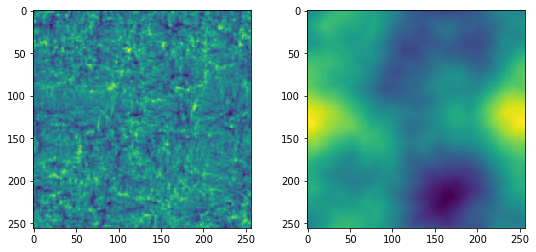

12


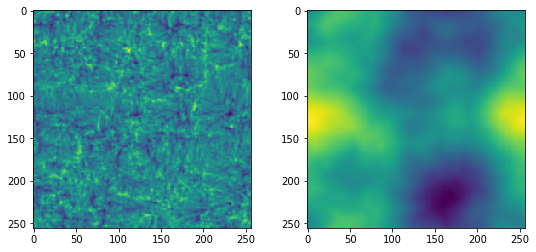

13


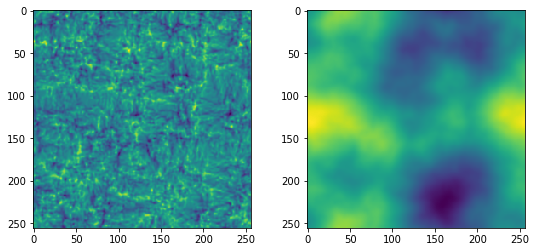

14


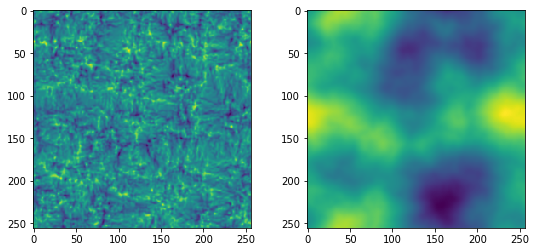

15


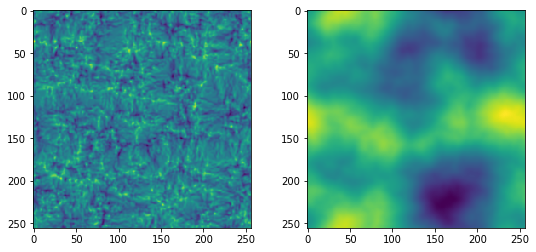

16


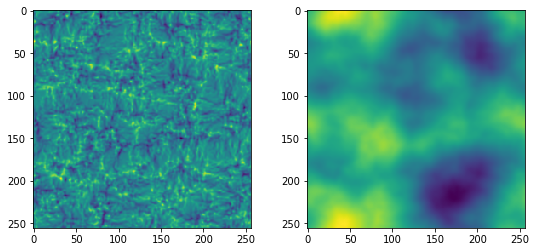

17


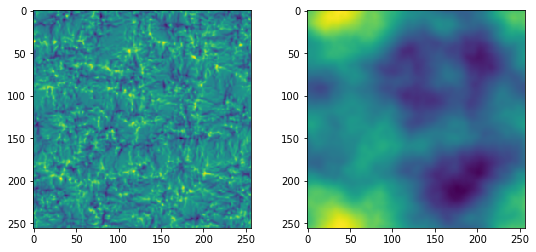

18


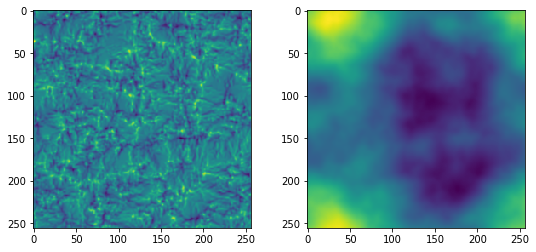

19


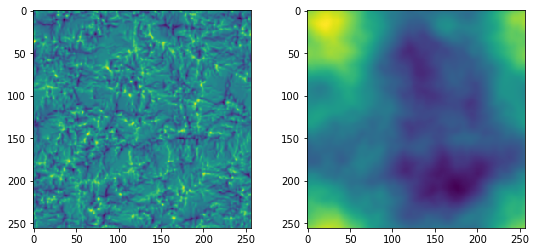

20


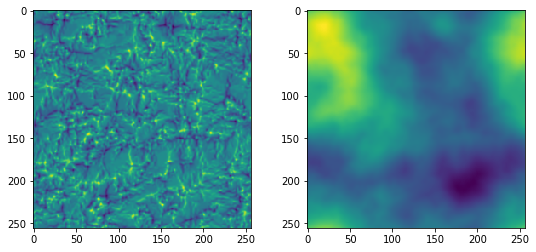

21


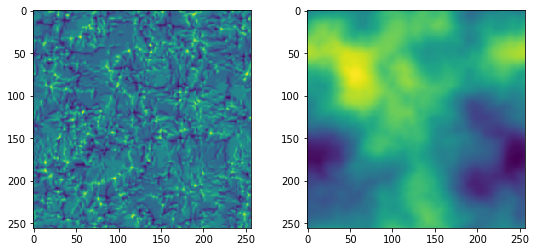

22


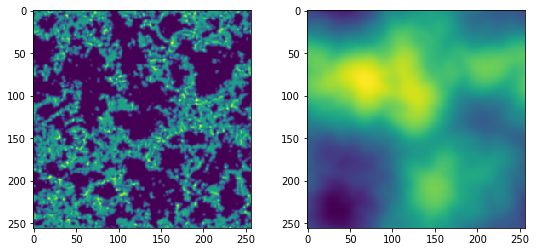

23


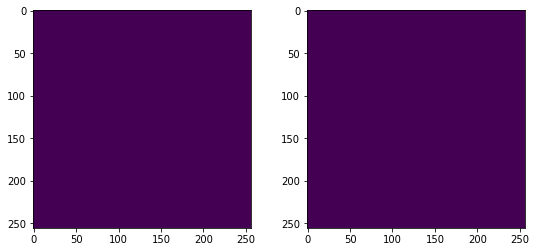

24


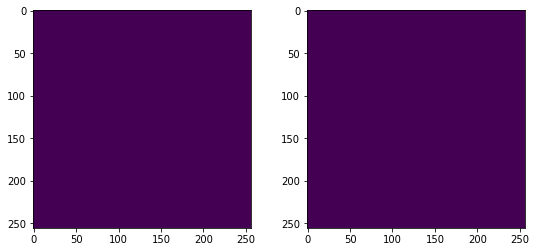

25


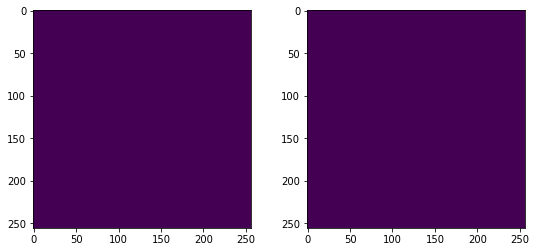

26


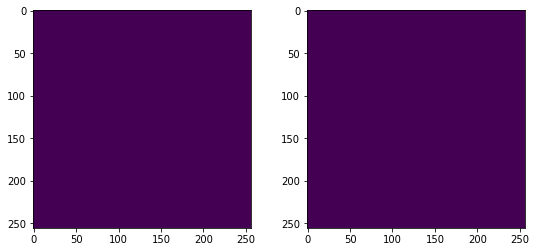

27


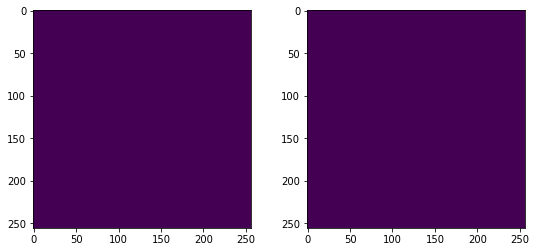

28


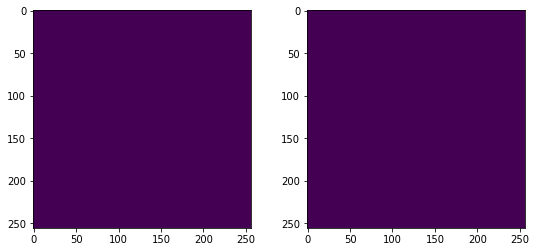

29


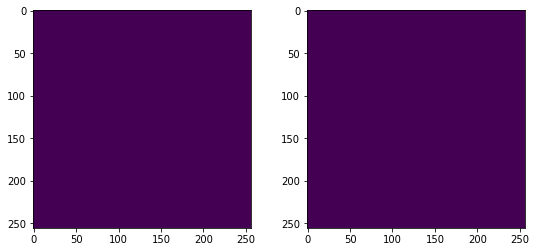

30


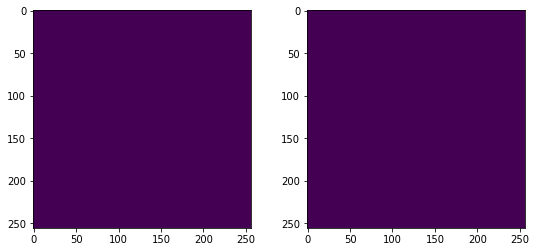

31


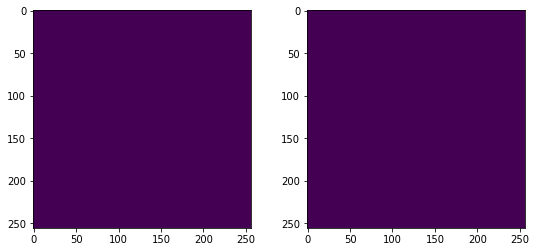

32


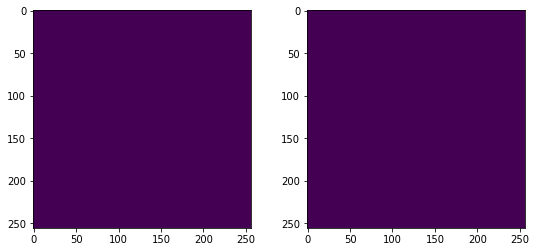

33


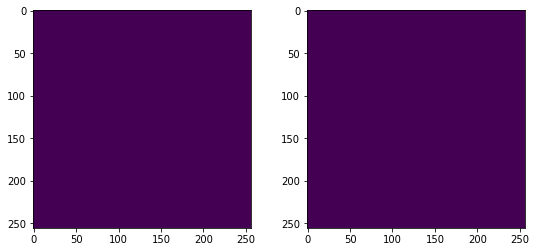

34


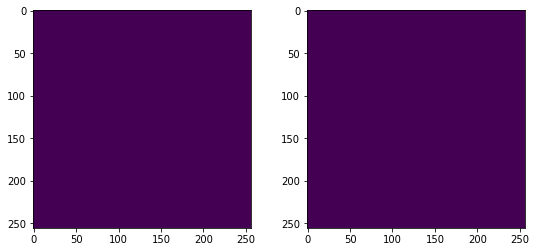

35


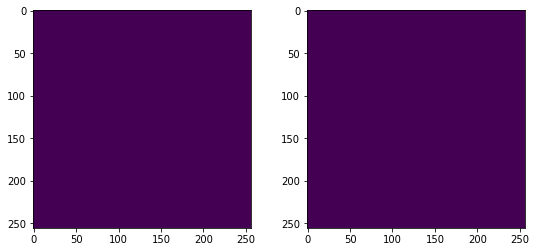

36


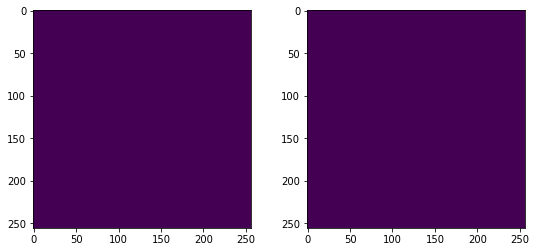

37


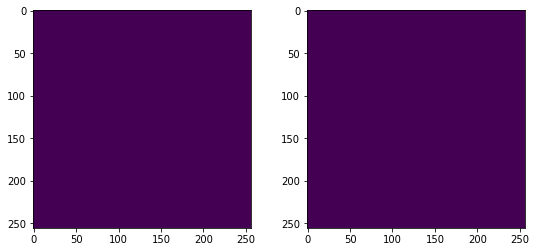

38


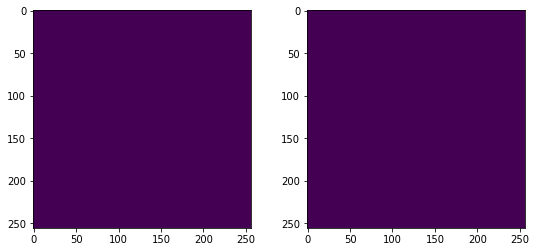

39


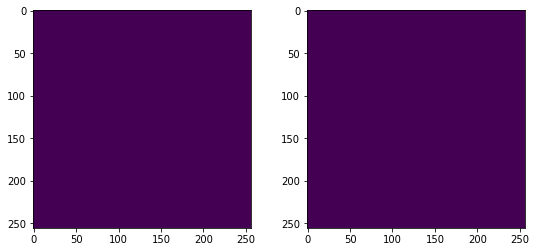

40


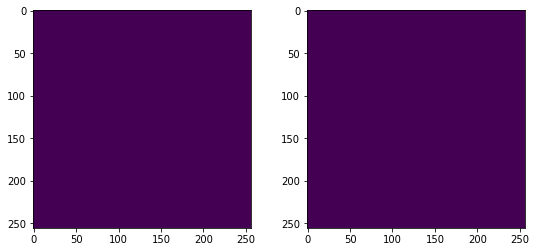

41


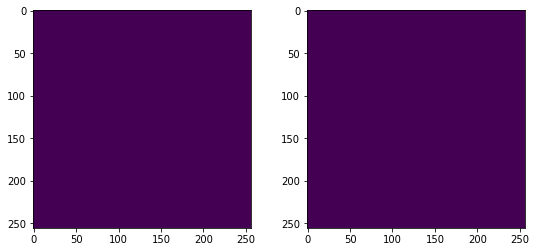

42


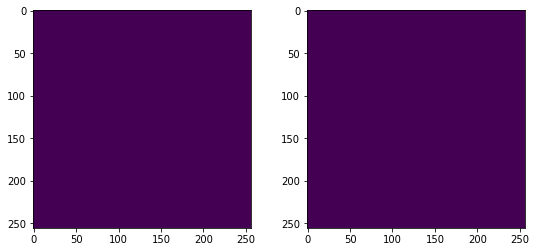

43


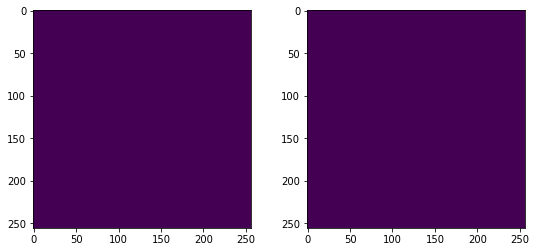

44


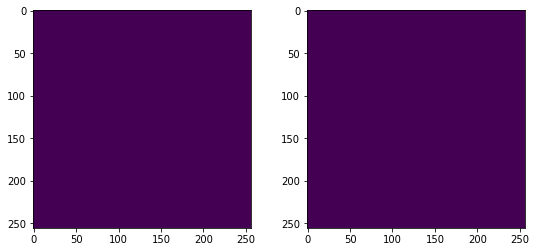

45


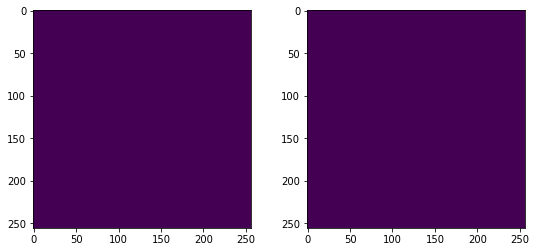

46


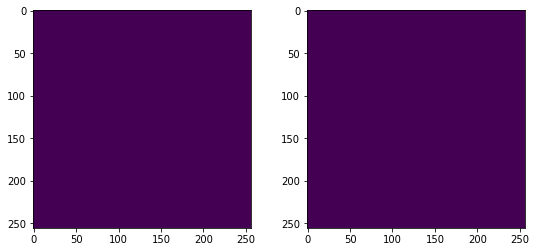

47


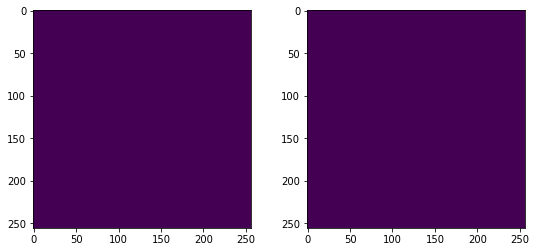

48


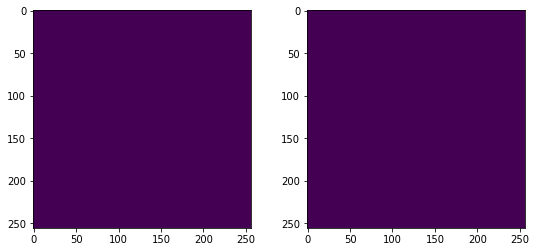

49


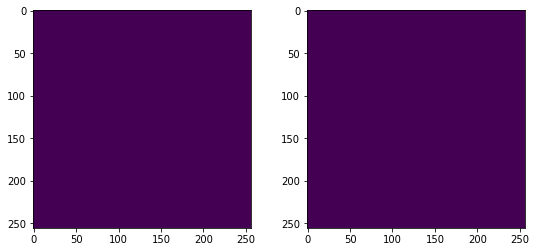

50


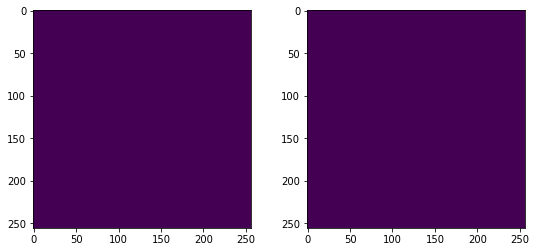

In [10]:
#Location and thickness of the lens
thick = 200
for i in xrange(51-thick%10):
    #print 'a'
    plane_center = (i*10.+thick)*snap.Mpc_over_h
    plane_thickness = thick*snap.Mpc_over_h


    #Cut a two dimensional lens
    density_2d,res,npart = snap.cutPlaneGaussianGrid(normal=2,center=plane_center,thickness=plane_thickness,plane_resolution=256,kind="density")
    potential_2d,res,npart = snap.cutPlaneGaussianGrid(normal=2,center=plane_center,thickness=plane_thickness,plane_resolution=256,kind="potential")


    print i
    fig = plt.figure(figsize= (9,4))
    plt.subplot(121)
    plt.imshow(density_2d)
    plt.subplot(122)
    plt.imshow(potential_2d)
    plt.show()
    

---

In [11]:
#Integrate up to this redshift
z = 0.5
chi_max = snap.cosmology.comoving_distance(z)
chi_max

<Quantity 1800.27323685 Mpc>

In [12]:
#Lens discretization
num_lenses = 20

thickness = chi_max / num_lenses
chi_start = thickness/2
chi_end = chi_max - thickness/2

#Lens centers
chi_centers = np.linspace(chi_start.value,chi_end.value,num_lenses)*chi_max.unit
chi_centers

<Quantity [  45.00683092, 135.02049276, 225.03415461, 315.04781645,
            405.06147829, 495.07514013, 585.08880198, 675.10246382,
            765.11612566, 855.1297875 , 945.14344934,1035.15711119,
           1125.17077303,1215.18443487,1305.19809671,1395.21175856,
           1485.2254204 ,1575.23908224,1665.25274408,1755.26640593] Mpc>

In [13]:
#Cut the lenses and add them to the raytracer
tracer = RayTracer()
for i,chi in enumerate(chi_centers):
    print i,
    zlens = z_at_value(snap.cosmology.comoving_distance,chi)
    d,r,n = snap.cutPlaneGaussianGrid(normal=2,center=chi,thickness=thickness,plane_resolution=512,kind="potential", smooth=1.0)
    lens = PotentialPlane(d.value,angle=snap.header["box_size"],comoving_distance=chi,redshift=zlens,cosmology=snap.cosmology,unit=u.rad**2)
    tracer.addLens(lens)

#Add a fudge lens at the end (needed by ODE solver implementation)
chi_fudge = chi_end + thickness
z_fudge = 1000.
tracer.addLens(PotentialPlane(np.zeros((256,256)),angle=snap.header["box_size"],redshift=z_fudge,comoving_distance=chi_fudge,cosmology=snap.cosmology,num_particles=None))

#Order lenses
tracer.reorderLenses()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19


In [14]:
#Field of view
fov = 90*u.deg
fov_resolution = 256

#Initial ray positions
b = np.linspace(0.,fov.value,fov_resolution)
pos = np.array(np.meshgrid(b,b))*fov.unit

In [15]:
conv_born = tracer.convergenceBorn(pos,z=z)
conv_born = ConvergenceMap(conv_born,angle=fov)

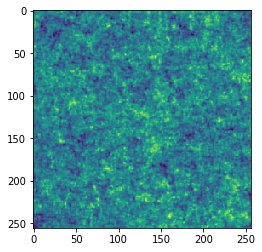

In [16]:
plt.imshow(conv_born.data)

TypeError: peakCount() takes at least 2 arguments (1 given)